# Mod√®le de R√©gression Lin√©aire pour la Pr√©diction du Path Loss Indoor

Ce notebook pr√©sente la cr√©ation et l'√©valuation d'un mod√®le de r√©gression lin√©aire pour pr√©dire le path loss en environnement indoor.

## Objectifs :
- Cr√©er un mod√®le de r√©gression lin√©aire avec √©quation explicite
- √âvaluer les performances du mod√®le
- Choisir les bons param√®tres et features
- Visualiser les r√©sultats et l'√©quation construite
- Sauvegarder le mod√®le et l'√©quation
- Comparer avec le mod√®le XGBoost existant

In [ ]:
# Imports des biblioth√®ques n√©cessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import joblib
import warnings
import os
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Biblioth√®ques import√©es avec succ√®s!")

Biblioth√®ques import√©es avec succ√®s!


In [4]:
# Chargement des donn√©es
data_path = 'indoor_pathloss_dataset.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset charg√© avec succ√®s : {df.shape[0]} lignes, {df.shape[1]} colonnes")
else:
    # Essayer dans le dossier parent
    data_path = '../model xgboost/indoor_pathloss_dataset.csv'
    df = pd.read_csv(data_path)
    print(f"Dataset charg√© depuis le dossier parent : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Affichage des premi√®res lignes
print("\nPremi√®res lignes du dataset :")
print(df.head())

print("\nInformations sur le dataset :")
print(df.info())

print("\nStatistiques descriptives :")
print(df.describe())

Dataset charg√© avec succ√®s : 200000 lignes, 5 colonnes

Premi√®res lignes du dataset :
   distance  numwall  etage  frequence  pathloss
0     23.46        2      0       5500    109.83
1     13.24        4      1       5000    119.57
2     26.87       12      1       5800    193.98
3     59.07       12      5       2400    281.14
4     12.15        1      0       2450     82.83

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   distance   200000 non-null  float64
 1   numwall    200000 non-null  int64  
 2   etage      200000 non-null  int64  
 3   frequence  200000 non-null  int64  
 4   pathloss   200000 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 7.6 MB
None

Statistiques descriptives :
            distance        numwall          etage      frequence  \
count  200000.000000  200000.000000 

Colonnes disponibles :
['distance', 'numwall', 'etage', 'frequence', 'pathloss']

Valeurs manquantes :
distance     0
numwall      0
etage        0
frequence    0
pathloss     0
dtype: int64


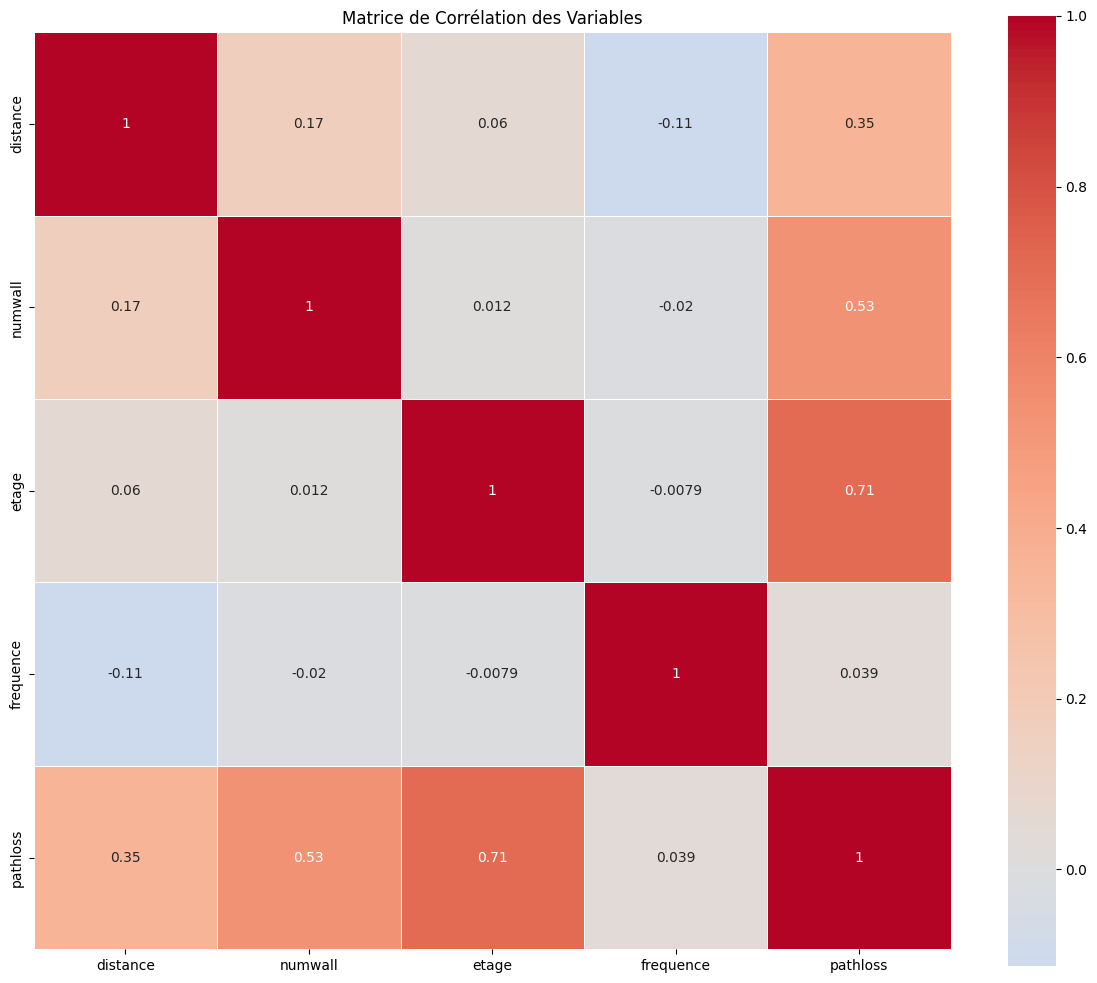


Variable cible identifi√©e : pathloss


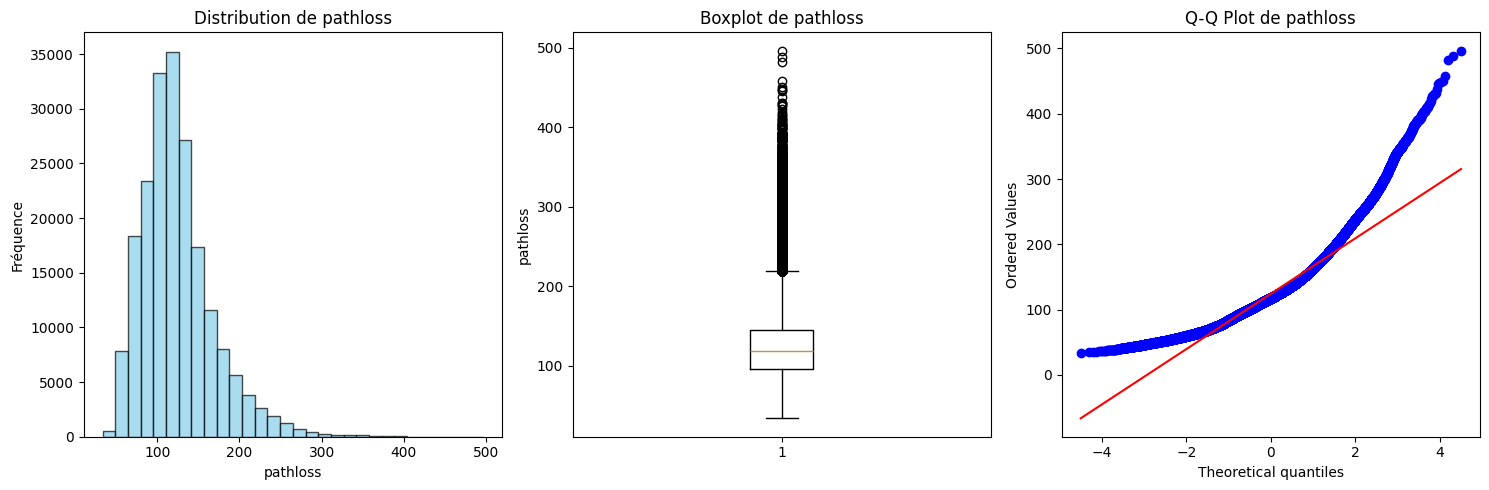


Statistiques de pathloss :
Moyenne : 124.42
M√©diane : 117.75
√âcart-type : 43.99
Min : 33.54
Max : 496.40


In [5]:
# Analyse exploratoire des donn√©es
print("Colonnes disponibles :")
print(df.columns.tolist())

# V√©rification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# Matrice de corr√©lation
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corr√©lation des Variables')
plt.tight_layout()
plt.show()

# Distribution de la variable cible (Path Loss)
target_col = 'path_loss_db' if 'path_loss_db' in df.columns else df.columns[-1]
print(f"\nVariable cible identifi√©e : {target_col}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df[target_col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Distribution de {target_col}')
plt.xlabel(target_col)
plt.ylabel('Fr√©quence')

plt.subplot(1, 3, 2)
plt.boxplot(df[target_col])
plt.title(f'Boxplot de {target_col}')
plt.ylabel(target_col)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df[target_col], dist="norm", plot=plt)
plt.title(f'Q-Q Plot de {target_col}')

plt.tight_layout()
plt.show()

print(f"\nStatistiques de {target_col} :")
print(f"Moyenne : {df[target_col].mean():.2f}")
print(f"M√©diane : {df[target_col].median():.2f}")
print(f"√âcart-type : {df[target_col].std():.2f}")
print(f"Min : {df[target_col].min():.2f}")
print(f"Max : {df[target_col].max():.2f}")

Features s√©lectionn√©es : ['distance', 'numwall', 'etage', 'frequence']
Target : pathloss

Shape des features : (200000, 4)
Shape de la target : (200000,)


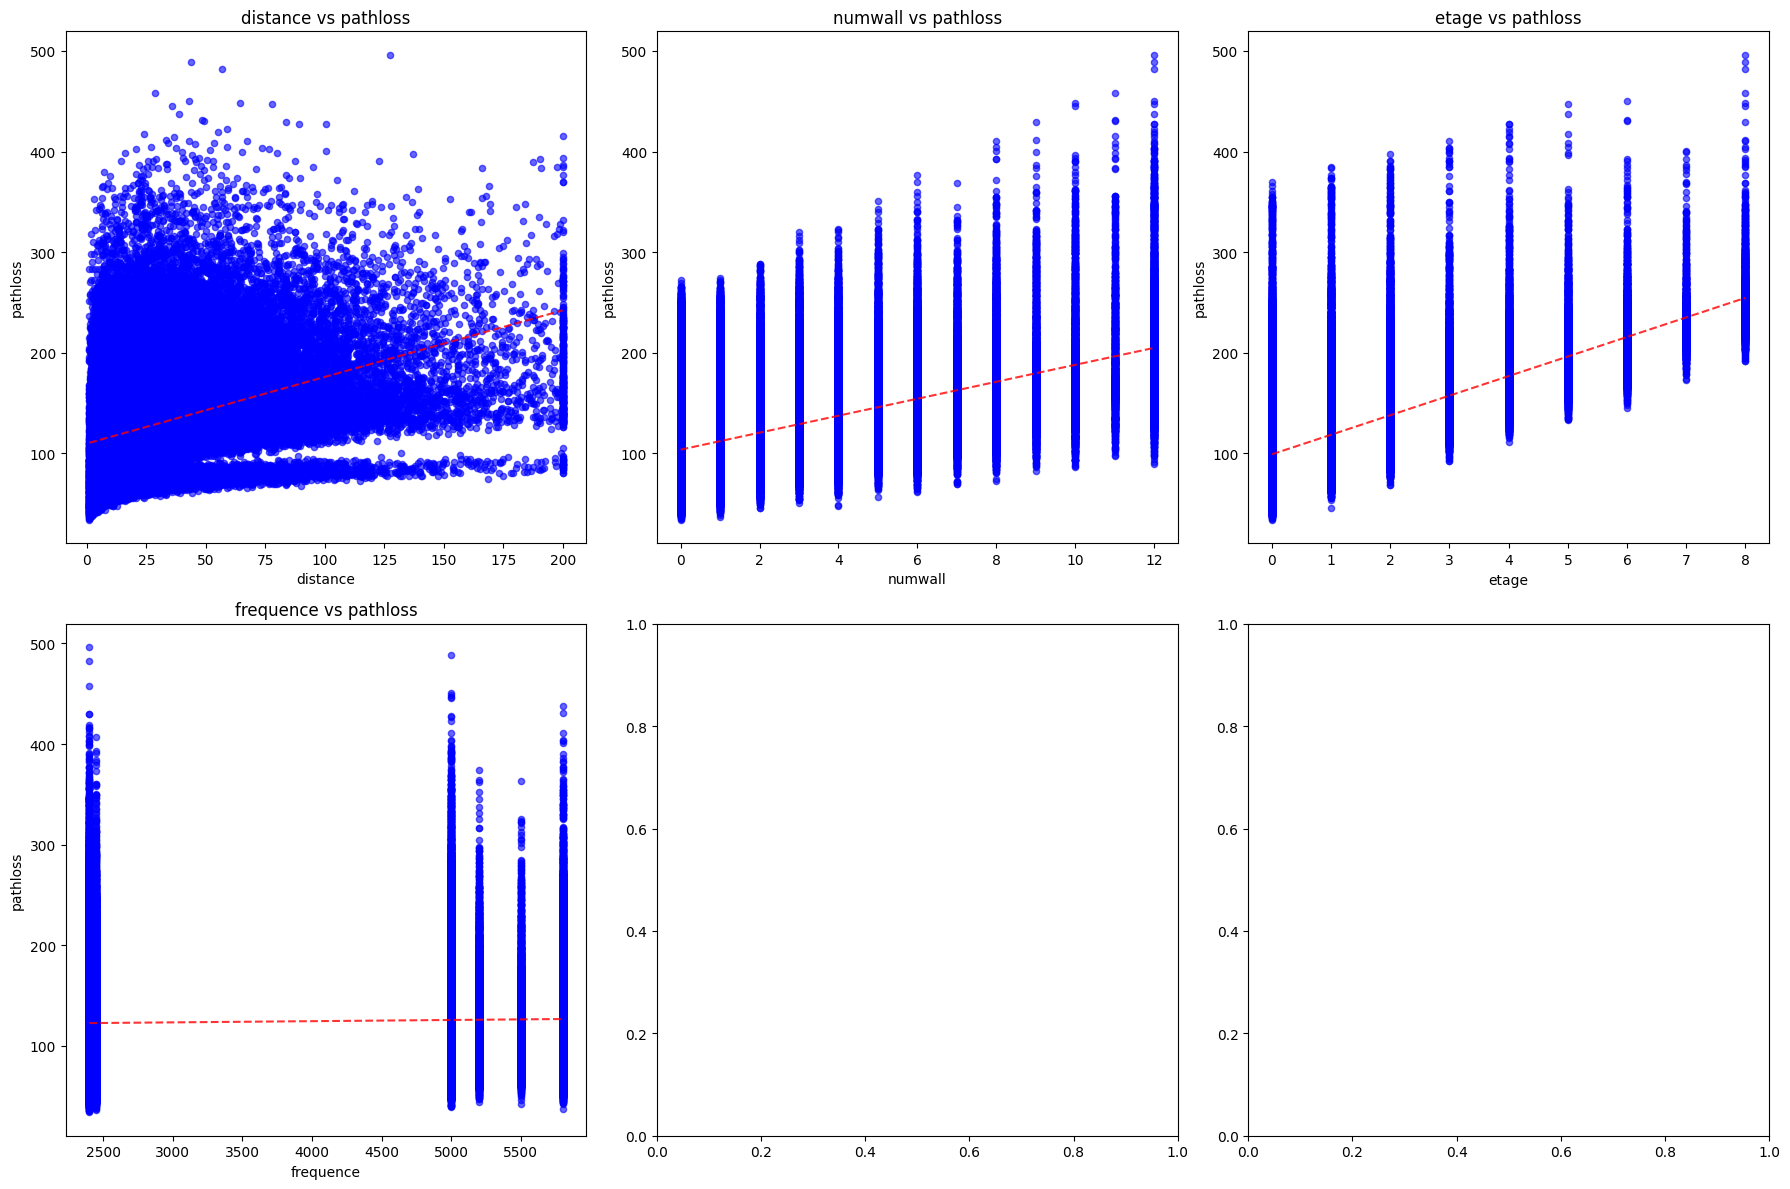


Features s√©lectionn√©es par SelectKBest (top 4) :
  etage: 198335.49
  numwall: 78722.80
  distance: 28789.01
  frequence: 307.28

Shape finale des features : (200000, 4)


In [6]:
# Pr√©paration des donn√©es et s√©lection des features
# Identifier automatiquement les features et la target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'path_loss_db' if 'path_loss_db' in numeric_cols else numeric_cols[-1]
feature_cols = [col for col in numeric_cols if col != target_col]

print(f"Features s√©lectionn√©es : {feature_cols}")
print(f"Target : {target_col}")

# S√©paration des features et de la target
X = df[feature_cols]
y = df[target_col]

print(f"\nShape des features : {X.shape}")
print(f"Shape de la target : {y.shape}")

# Visualisation de la relation entre features principales et target
n_features = min(6, len(feature_cols))
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(feature_cols[:n_features]):
    axes[i].scatter(X[feature], y, alpha=0.6, color='blue', s=20)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_col)
    axes[i].set_title(f'{feature} vs {target_col}')
    
    # Ajouter une ligne de tendance
    z = np.polyfit(X[feature], y, 1)
    p = np.poly1d(z)
    axes[i].plot(X[feature].sort_values(), p(X[feature].sort_values()), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# S√©lection des meilleures features avec SelectKBest
k_best = min(10, len(feature_cols))  # S√©lectionner au maximum 10 features
selector = SelectKBest(score_func=f_regression, k=k_best)
X_selected = selector.fit_transform(X, y)
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

print(f"\nFeatures s√©lectionn√©es par SelectKBest (top {k_best}) :")
feature_scores = dict(zip(feature_cols, selector.scores_))
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_features[:k_best]:
    print(f"  {feature}: {score:.2f}")

# Utiliser les features s√©lectionn√©es
X_final = X[selected_features]
print(f"\nShape finale des features : {X_final.shape}")

In [7]:
# Division des donn√©es en ensembles d'entra√Ænement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Taille de l'ensemble d'entra√Ænement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")

# Standardisation des donn√©es (important pour la r√©gression lin√©aire)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDonn√©es standardis√©es :")
print(f"Moyenne des features d'entra√Ænement : {X_train_scaled.mean(axis=0)}")
print(f"√âcart-type des features d'entra√Ænement : {X_train_scaled.std(axis=0)}")

# Sauvegarde des noms des features pour l'√©quation
feature_names = selected_features.copy()
print(f"\nFeatures utilis√©es pour le mod√®le : {feature_names}")

Taille de l'ensemble d'entra√Ænement : (160000, 4)
Taille de l'ensemble de test : (40000, 4)

Donn√©es standardis√©es :
Moyenne des features d'entra√Ænement : [-2.87325719e-17 -7.63833441e-18  3.81916720e-17  4.61852778e-17]
√âcart-type des features d'entra√Ænement : [1. 1. 1. 1.]

Features utilis√©es pour le mod√®le : ['distance', 'numwall', 'etage', 'frequence']


In [8]:
# Cr√©ation et entra√Ænement de diff√©rents mod√®les de r√©gression lin√©aire
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000)
}

# Entra√Ænement et √©valuation des mod√®les
model_results = {}

for name, model in models.items():
    print(f"\n=== Entra√Ænement du mod√®le {name} ===")
    
    # Entra√Ænement
    model.fit(X_train_scaled, y_train)
    
    # Pr√©dictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # M√©triques
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Validation crois√©e
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }
    
    print(f"R¬≤ Train: {train_r2:.4f}, R¬≤ Test: {test_r2:.4f}")
    print(f"RMSE Train: {train_rmse:.4f}, RMSE Test: {test_rmse:.4f}")
    print(f"MAE Train: {train_mae:.4f}, MAE Test: {test_mae:.4f}")
    print(f"CV R¬≤ : {cv_scores.mean():.4f} ¬± {cv_scores.std():.4f}")

# R√©sum√© des performances
print("\n" + "="*50)
print("R√âSUM√â DES PERFORMANCES")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train R¬≤': [result['train_r2'] for result in model_results.values()],
    'Test R¬≤': [result['test_r2'] for result in model_results.values()],
    'Train RMSE': [result['train_rmse'] for result in model_results.values()],
    'Test RMSE': [result['test_rmse'] for result in model_results.values()],
    'CV R¬≤ Mean': [result['cv_r2_mean'] for result in model_results.values()],
    'CV R¬≤ Std': [result['cv_r2_std'] for result in model_results.values()]
})

print(results_df.round(4))


=== Entra√Ænement du mod√®le Linear Regression ===
R¬≤ Train: 0.8295, R¬≤ Test: 0.8294
RMSE Train: 18.1618, RMSE Test: 18.1632
MAE Train: 12.1352, MAE Test: 12.0985
CV R¬≤ : 0.8295 ¬± 0.0036

=== Entra√Ænement du mod√®le Ridge ===
R¬≤ Train: 0.8295, R¬≤ Test: 0.8294
RMSE Train: 18.1618, RMSE Test: 18.1632
MAE Train: 12.1352, MAE Test: 12.0985
CV R¬≤ : 0.8295 ¬± 0.0036

=== Entra√Ænement du mod√®le Lasso ===
R¬≤ Train: 0.8276, R¬≤ Test: 0.8272
RMSE Train: 18.2675, RMSE Test: 18.2769
MAE Train: 12.2745, MAE Test: 12.2298
CV R¬≤ : 0.8275 ¬± 0.0034

=== Entra√Ænement du mod√®le ElasticNet ===
R¬≤ Train: 0.7388, R¬≤ Test: 0.7381
RMSE Train: 22.4835, RMSE Test: 22.5041
MAE Train: 15.7789, MAE Test: 15.7348
CV R¬≤ : 0.7387 ¬± 0.0026

R√âSUM√â DES PERFORMANCES
               Model  Train R¬≤  Test R¬≤  Train RMSE  Test RMSE  CV R¬≤ Mean  \
0  Linear Regression    0.8295   0.8294     18.1618    18.1632      0.8295   
1              Ridge    0.8295   0.8294     18.1618    18.1632      0.8295   

In [9]:
# S√©lection du meilleur mod√®le bas√© sur le R¬≤ de test et la validation crois√©e
best_model_name = max(model_results.keys(), 
                     key=lambda x: model_results[x]['test_r2'] * 0.7 + model_results[x]['cv_r2_mean'] * 0.3)

print(f"Meilleur mod√®le s√©lectionn√© : {best_model_name}")
print(f"R¬≤ Test : {model_results[best_model_name]['test_r2']:.4f}")
print(f"CV R¬≤ : {model_results[best_model_name]['cv_r2_mean']:.4f}")

# Optimisation des hyperparam√®tres pour le meilleur mod√®le
best_model = model_results[best_model_name]['model']

if best_model_name == 'Ridge':
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
elif best_model_name == 'Lasso':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
elif best_model_name == 'ElasticNet':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
else:
    param_grid = {}

if param_grid:
    print(f"\nOptimisation des hyperparam√®tres pour {best_model_name}...")
    
    # Recr√©er le mod√®le pour l'optimisation
    if best_model_name == 'Ridge':
        model_for_grid = Ridge(random_state=42)
    elif best_model_name == 'Lasso':
        model_for_grid = Lasso(random_state=42, max_iter=2000)
    elif best_model_name == 'ElasticNet':
        model_for_grid = ElasticNet(random_state=42, max_iter=2000)
    
    grid_search = GridSearchCV(model_for_grid, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Meilleurs param√®tres : {grid_search.best_params_}")
    print(f"Meilleur score CV : {grid_search.best_score_:.4f}")
    
    # Utiliser le mod√®le optimis√©
    optimized_model = grid_search.best_estimator_
else:
    optimized_model = best_model
    print(f"\nAucune optimisation n√©cessaire pour {best_model_name}")

# R√©-entra√Æner avec le mod√®le optimis√©
optimized_model.fit(X_train_scaled, y_train)
y_train_pred_opt = optimized_model.predict(X_train_scaled)
y_test_pred_opt = optimized_model.predict(X_test_scaled)

# M√©triques finales
final_train_r2 = r2_score(y_train, y_train_pred_opt)
final_test_r2 = r2_score(y_test, y_test_pred_opt)
final_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_opt))
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

print(f"\n=== PERFORMANCES DU MOD√àLE FINAL ({best_model_name}) ===")
print(f"R¬≤ Train: {final_train_r2:.4f}")
print(f"R¬≤ Test: {final_test_r2:.4f}")
print(f"RMSE Train: {final_train_rmse:.4f}")
print(f"RMSE Test: {final_test_rmse:.4f}")

# Stocker le mod√®le final
final_model = optimized_model

Meilleur mod√®le s√©lectionn√© : Linear Regression
R¬≤ Test : 0.8294
CV R¬≤ : 0.8295

Aucune optimisation n√©cessaire pour Linear Regression

=== PERFORMANCES DU MOD√àLE FINAL (Linear Regression) ===
R¬≤ Train: 0.8295
R¬≤ Test: 0.8294
RMSE Train: 18.1618
RMSE Test: 18.1632


In [10]:
# Extraction de l'√©quation math√©matique explicite
def create_equation_string(model, feature_names, scaler, target_name):
    """
    Cr√©e l'√©quation math√©matique explicite du mod√®le de r√©gression lin√©aire
    """
    coefficients = model.coef_
    intercept = model.intercept_
    
    # R√©cup√©rer les param√®tres de standardisation
    means = scaler.mean_
    scales = scaler.scale_
    
    # Calculer l'intercept ajust√© pour les donn√©es non standardis√©es
    adjusted_intercept = intercept - np.sum(coefficients * means / scales)
    
    # Calculer les coefficients ajust√©s pour les donn√©es non standardis√©es
    adjusted_coefficients = coefficients / scales
    
    # Cr√©er l'√©quation sous forme de cha√Æne
    equation_parts = [f"{target_name} = {adjusted_intercept:.6f}"]
    
    for i, (coef, feature) in enumerate(zip(adjusted_coefficients, feature_names)):
        if coef >= 0:
            equation_parts.append(f" + {coef:.6f} * {feature}")
        else:
            equation_parts.append(f" - {abs(coef):.6f} * {feature}")
    
    equation_string = "".join(equation_parts)
    
    return equation_string, adjusted_coefficients, adjusted_intercept

# Extraire l'√©quation
equation_string, coefficients_original, intercept_original = create_equation_string(
    final_model, feature_names, scaler, target_col
)

print("="*80)
print("√âQUATION MATH√âMATIQUE DU MOD√àLE DE R√âGRESSION LIN√âAIRE")
print("="*80)
print()
print("√âquation compl√®te :")
print(equation_string)
print()

# Affichage format√© de l'√©quation
print("√âquation format√©e :")
print(f"{target_col} = {intercept_original:.3f}", end="")
for coef, feature in zip(coefficients_original, feature_names):
    if coef >= 0:
        print(f" + {coef:.3f}√ó{feature}", end="")
    else:
        print(f" - {abs(coef):.3f}√ó{feature}", end="")
print()
print()

# Tableau des coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_original,
    'Coefficient_Abs': np.abs(coefficients_original)
}).sort_values('Coefficient_Abs', ascending=False)

print("Coefficients par ordre d'importance :")
print(coefficients_df.round(6))
print()
print(f"Intercept : {intercept_original:.6f}")

# Analyse de l'importance des features
print("\nAnalyse de l'importance des features :")
for _, row in coefficients_df.head().iterrows():
    impact = "positif" if row['Coefficient'] > 0 else "n√©gatif"
    print(f"- {row['Feature']}: coefficient {row['Coefficient']:.3f} (impact {impact})")

# Sauvegarde de l'√©quation
equation_info = {
    'equation_string': equation_string,
    'coefficients': dict(zip(feature_names, coefficients_original)),
    'intercept': intercept_original,
    'feature_names': feature_names,
    'target_name': target_col,
    'model_type': best_model_name,
    'r2_score': final_test_r2,
    'rmse': final_test_rmse
}

√âQUATION MATH√âMATIQUE DU MOD√àLE DE R√âGRESSION LIN√âAIRE

√âquation compl√®te :
pathloss = 60.454131 + 0.446223 * distance + 7.663657 * numwall + 18.919651 * etage + 0.002478 * frequence

√âquation format√©e :
pathloss = 60.454 + 0.446√ódistance + 7.664√ónumwall + 18.920√óetage + 0.002√ófrequence

Coefficients par ordre d'importance :
     Feature  Coefficient  Coefficient_Abs
2      etage    18.919651        18.919651
1    numwall     7.663657         7.663657
0   distance     0.446223         0.446223
3  frequence     0.002478         0.002478

Intercept : 60.454131

Analyse de l'importance des features :
- etage: coefficient 18.920 (impact positif)
- numwall: coefficient 7.664 (impact positif)
- distance: coefficient 0.446 (impact positif)
- frequence: coefficient 0.002 (impact positif)


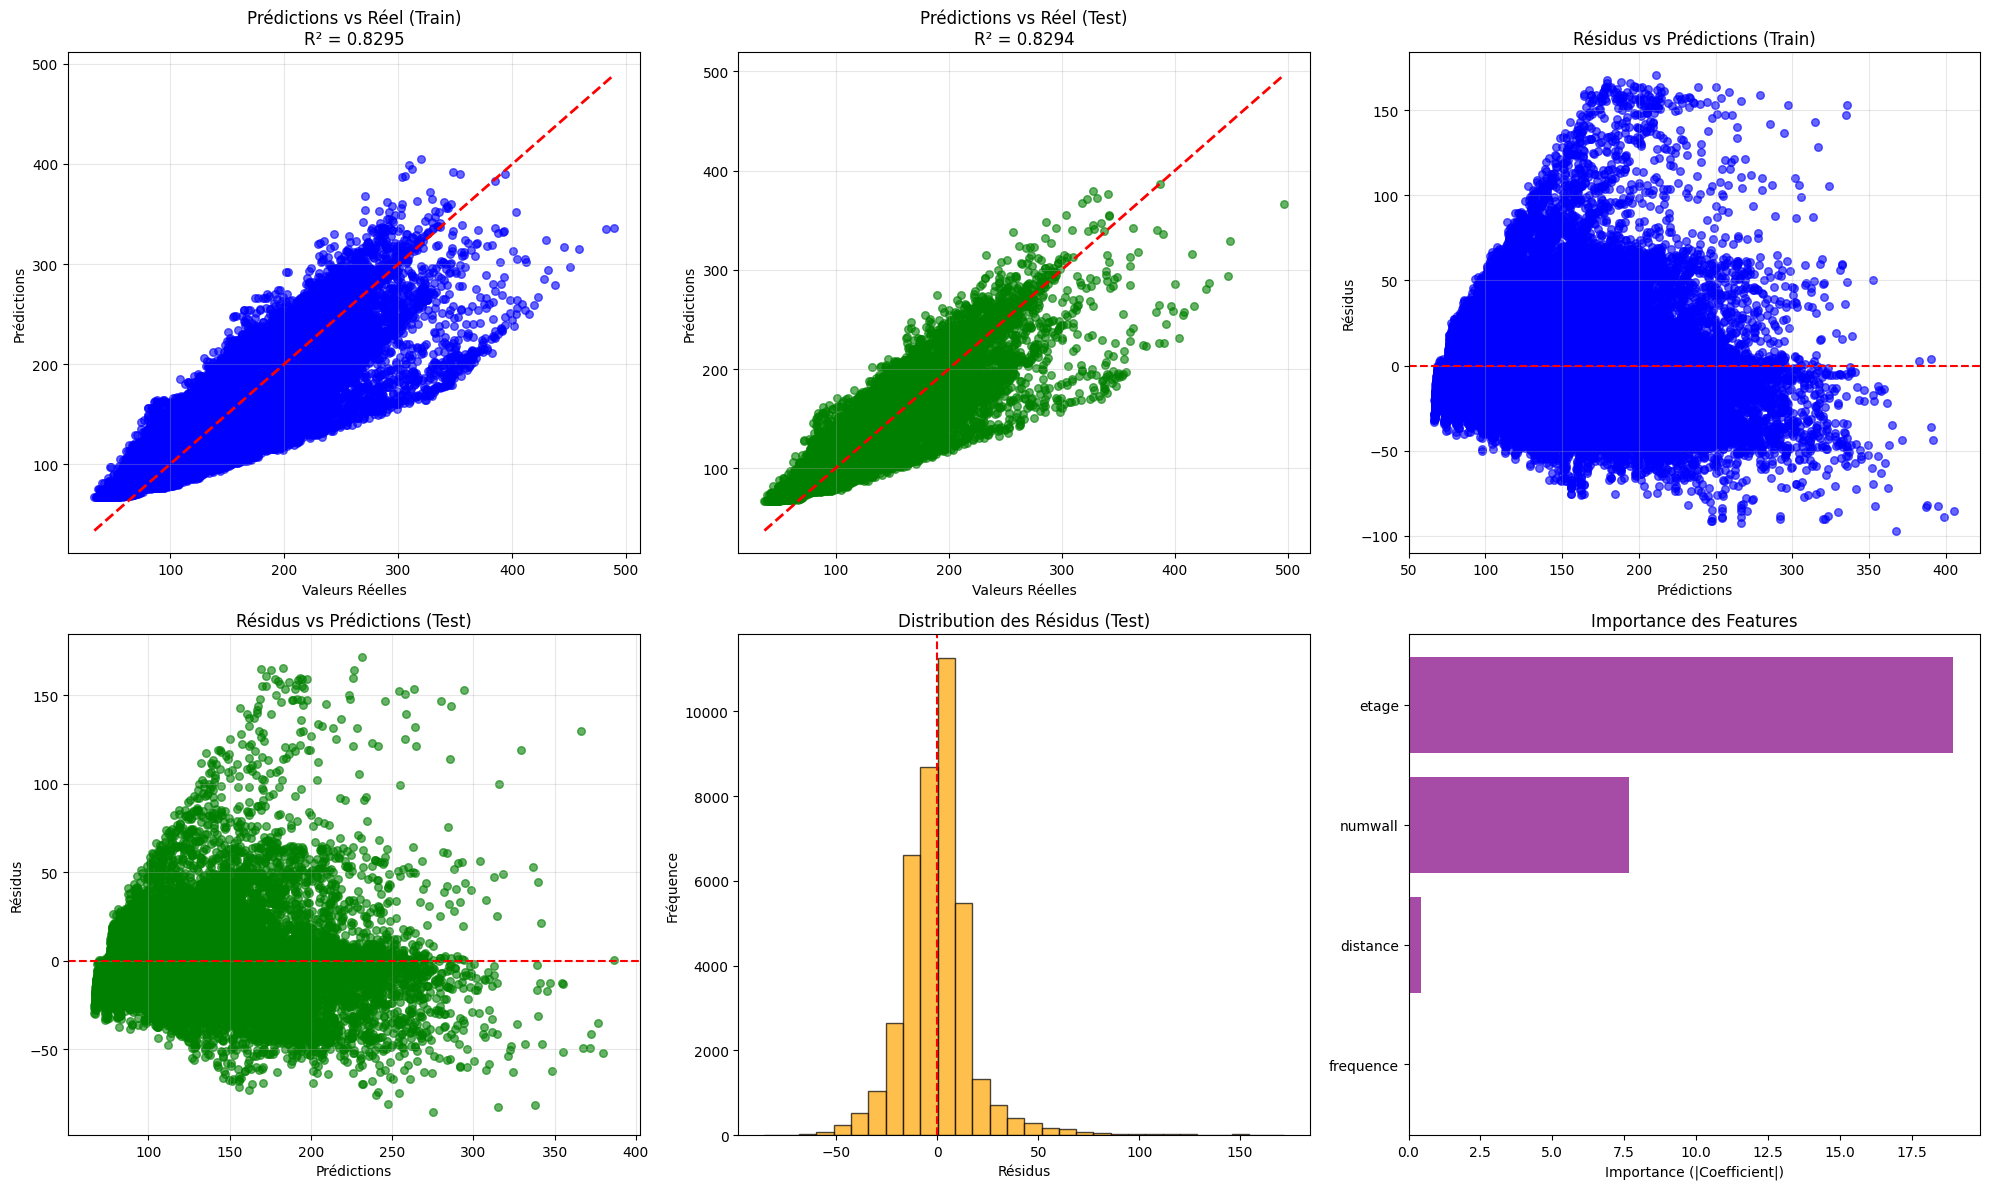

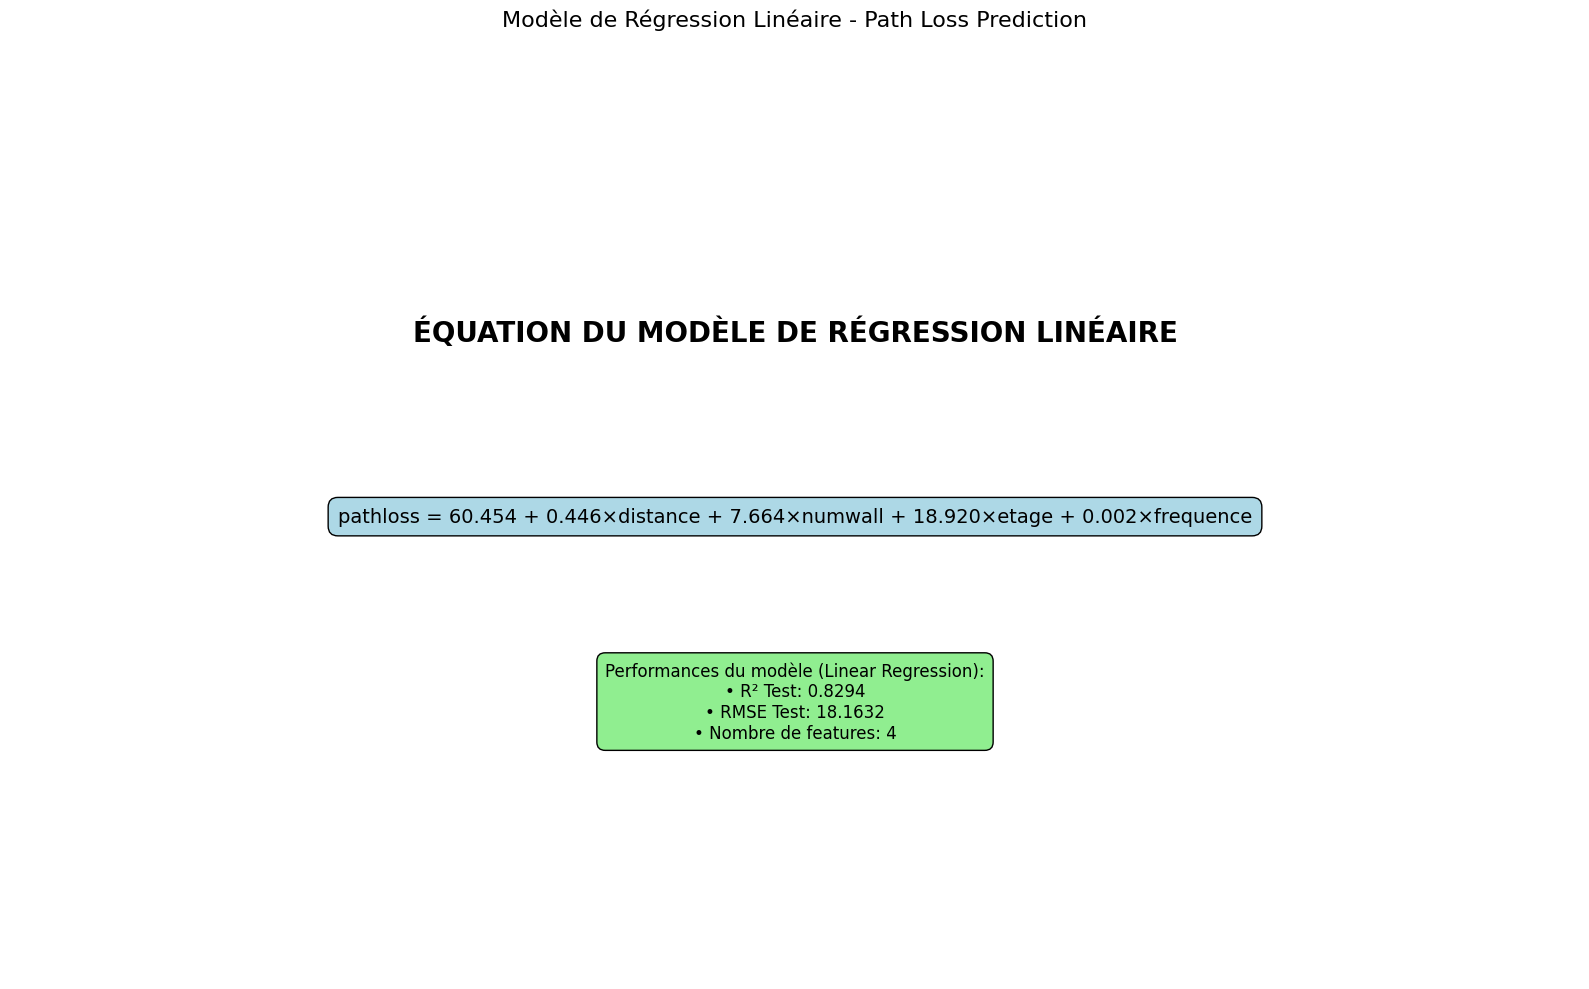

In [11]:
# Visualisations des r√©sultats
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Pr√©dictions vs Valeurs r√©elles (Train)
axes[0, 0].scatter(y_train, y_train_pred_opt, alpha=0.6, color='blue', s=30)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valeurs R√©elles')
axes[0, 0].set_ylabel('Pr√©dictions')
axes[0, 0].set_title(f'Pr√©dictions vs R√©el (Train)\nR¬≤ = {final_train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Pr√©dictions vs Valeurs r√©elles (Test)
axes[0, 1].scatter(y_test, y_test_pred_opt, alpha=0.6, color='green', s=30)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valeurs R√©elles')
axes[0, 1].set_ylabel('Pr√©dictions')
axes[0, 1].set_title(f'Pr√©dictions vs R√©el (Test)\nR¬≤ = {final_test_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. R√©sidus (Train)
residuals_train = y_train - y_train_pred_opt
axes[0, 2].scatter(y_train_pred_opt, residuals_train, alpha=0.6, color='blue', s=30)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Pr√©dictions')
axes[0, 2].set_ylabel('R√©sidus')
axes[0, 2].set_title('R√©sidus vs Pr√©dictions (Train)')
axes[0, 2].grid(True, alpha=0.3)

# 4. R√©sidus (Test)
residuals_test = y_test - y_test_pred_opt
axes[1, 0].scatter(y_test_pred_opt, residuals_test, alpha=0.6, color='green', s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Pr√©dictions')
axes[1, 0].set_ylabel('R√©sidus')
axes[1, 0].set_title('R√©sidus vs Pr√©dictions (Test)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribution des r√©sidus
axes[1, 1].hist(residuals_test, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('R√©sidus')
axes[1, 1].set_ylabel('Fr√©quence')
axes[1, 1].set_title('Distribution des R√©sidus (Test)')

# 6. Importance des coefficients
coef_abs = np.abs(coefficients_original)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coef_abs
}).sort_values('importance', ascending=True)

axes[1, 2].barh(range(len(feature_importance)), feature_importance['importance'], color='purple', alpha=0.7)
axes[1, 2].set_yticks(range(len(feature_importance)))
axes[1, 2].set_yticklabels(feature_importance['feature'])
axes[1, 2].set_xlabel('Importance (|Coefficient|)')
axes[1, 2].set_title('Importance des Features')

plt.tight_layout()
plt.show()

# Graphique s√©par√© pour l'√©quation visualis√©e
plt.figure(figsize=(16, 10))

# Cr√©er une visualisation de l'√©quation
plt.text(0.5, 0.7, '√âQUATION DU MOD√àLE DE R√âGRESSION LIN√âAIRE', 
         ha='center', va='center', fontsize=20, fontweight='bold', 
         transform=plt.gca().transAxes)

# √âquation format√©e
equation_text = f"{target_col} = {intercept_original:.3f}"
for coef, feature in zip(coefficients_original, feature_names):
    if coef >= 0:
        equation_text += f" + {coef:.3f}√ó{feature}"
    else:
        equation_text += f" - {abs(coef):.3f}√ó{feature}"

plt.text(0.5, 0.5, equation_text, ha='center', va='center', fontsize=14, 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue"))

# Informations sur les performances
perf_text = f"""Performances du mod√®le ({best_model_name}):
‚Ä¢ R¬≤ Test: {final_test_r2:.4f}
‚Ä¢ RMSE Test: {final_test_rmse:.4f}
‚Ä¢ Nombre de features: {len(feature_names)}"""

plt.text(0.5, 0.3, perf_text, ha='center', va='center', fontsize=12, 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen"))

plt.axis('off')
plt.title('Mod√®le de R√©gression Lin√©aire - Path Loss Prediction', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Mod√®le XGBoost charg√© avec succ√®s!
Type de l'objet charg√©: <class 'dict'>
Features XGBoost: ['distance', 'numwall', 'etage', 'frequence']
Features Linear: ['distance', 'numwall', 'etage', 'frequence']

COMPARAISON DES MOD√àLES
  M√©trique  R√©gression Lin√©aire  XGBoost
0       R¬≤               0.8294   0.8693
1     RMSE              18.1632  15.8968
2      MAE              12.0985   8.8638

Diff√©rence R¬≤ (Linear - XGBoost): -0.0399
Diff√©rence RMSE (Linear - XGBoost): 2.2664
‚úó XGBoost performe mieux en R¬≤
‚úó XGBoost a un RMSE plus faible


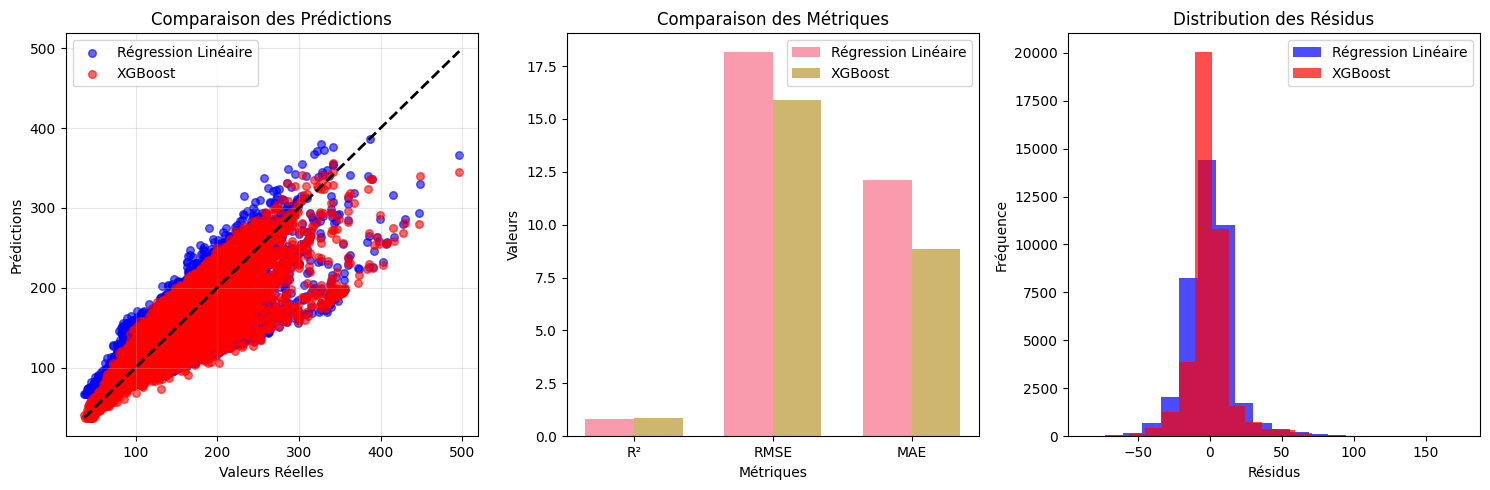


=== INFORMATIONS DES MOD√àLES ===
XGBoost:
  - Date: 2025-07-10 00:34:07
  - Type: XGBoost Regressor
  - R¬≤: 0.8662
  - RMSE: 16.0806
R√©gression Lin√©aire:
  - Type: Linear Regression
  - R¬≤: 0.8294
  - RMSE: 18.1632


In [15]:
# Comparaison avec le mod√®le XGBoost existant (structure model_info corrig√©e)
xgb_model_path = '../model xgboost/xgboost_radio_propagation_model.pkl'

if os.path.exists(xgb_model_path):
    try:
        # Charger le mod√®le XGBoost avec structure model_info
        xgb_model_info = joblib.load(xgb_model_path)
        print("Mod√®le XGBoost charg√© avec succ√®s!")
        print(f"Type de l'objet charg√©: {type(xgb_model_info)}")
        
        # V√©rifier la structure
        if isinstance(xgb_model_info, dict) and 'model' in xgb_model_info:
            xgb_model = xgb_model_info['model']
            xgb_feature_names = xgb_model_info['feature_names']
            
            print(f"Features XGBoost: {xgb_feature_names}")
            print(f"Features Linear: {feature_names}")
            
            # V√©rifier si les features correspondent
            if set(feature_names).issubset(set(xgb_feature_names)):
                # Utiliser les m√™mes features pour une comparaison √©quitable
                X_test_xgb = X_test[feature_names]  # Features originales sans standardisation
                y_test_pred_xgb = xgb_model.predict(X_test_xgb)
                
                # M√©triques XGBoost
                xgb_r2 = r2_score(y_test, y_test_pred_xgb)
                xgb_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
                xgb_mae = mean_absolute_error(y_test, y_test_pred_xgb)
                
                # Comparaison
                print("\n" + "="*60)
                print("COMPARAISON DES MOD√àLES")
                print("="*60)
                
                comparison_df = pd.DataFrame({
                    'M√©trique': ['R¬≤', 'RMSE', 'MAE'],
                    'R√©gression Lin√©aire': [final_test_r2, final_test_rmse, mean_absolute_error(y_test, y_test_pred_opt)],
                    'XGBoost': [xgb_r2, xgb_rmse, xgb_mae]
                })
                
                print(comparison_df.round(4))
                
                # Diff√©rence de performance
                r2_diff = final_test_r2 - xgb_r2
                rmse_diff = final_test_rmse - xgb_rmse
                
                print(f"\nDiff√©rence R¬≤ (Linear - XGBoost): {r2_diff:.4f}")
                print(f"Diff√©rence RMSE (Linear - XGBoost): {rmse_diff:.4f}")
                
                if r2_diff > 0:
                    print("‚úì La r√©gression lin√©aire performe mieux en R¬≤")
                else:
                    print("‚úó XGBoost performe mieux en R¬≤")
                    
                if rmse_diff < 0:
                    print("‚úì La r√©gression lin√©aire a un RMSE plus faible")
                else:
                    print("‚úó XGBoost a un RMSE plus faible")
                
                # Visualisation comparative
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.scatter(y_test, y_test_pred_opt, alpha=0.6, color='blue', label='R√©gression Lin√©aire', s=30)
                plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='red', label='XGBoost', s=30)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
                plt.xlabel('Valeurs R√©elles')
                plt.ylabel('Pr√©dictions')
                plt.title('Comparaison des Pr√©dictions')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 3, 2)
                metrics = ['R¬≤', 'RMSE', 'MAE']
                linear_values = [final_test_r2, final_test_rmse, mean_absolute_error(y_test, y_test_pred_opt)]
                xgb_values = [xgb_r2, xgb_rmse, xgb_mae]
                
                x = np.arange(len(metrics))
                width = 0.35
                
                plt.bar(x - width/2, linear_values, width, label='R√©gression Lin√©aire', alpha=0.7)
                plt.bar(x + width/2, xgb_values, width, label='XGBoost', alpha=0.7)
                plt.xlabel('M√©triques')
                plt.ylabel('Valeurs')
                plt.title('Comparaison des M√©triques')
                plt.xticks(x, metrics)
                plt.legend()
                
                plt.subplot(1, 3, 3)
                residuals_linear = y_test - y_test_pred_opt
                residuals_xgb = y_test - y_test_pred_xgb
                
                plt.hist(residuals_linear, bins=20, alpha=0.7, label='R√©gression Lin√©aire', color='blue')
                plt.hist(residuals_xgb, bins=20, alpha=0.7, label='XGBoost', color='red')
                plt.xlabel('R√©sidus')
                plt.ylabel('Fr√©quence')
                plt.title('Distribution des R√©sidus')
                plt.legend()
                
                plt.tight_layout()
                plt.show()
                
                # Afficher les informations des deux mod√®les
                print(f"\n=== INFORMATIONS DES MOD√àLES ===")
                print(f"XGBoost:")
                print(f"  - Date: {xgb_model_info.get('creation_date', 'N/A')}")
                print(f"  - Type: {xgb_model_info.get('model_type', 'N/A')}")
                print(f"  - R¬≤: {xgb_model_info['metrics']['r2_score']:.4f}")
                print(f"  - RMSE: {xgb_model_info['metrics']['rmse']:.4f}")
                
                print(f"R√©gression Lin√©aire:")
                print(f"  - Type: {best_model_name}")
                print(f"  - R¬≤: {final_test_r2:.4f}")
                print(f"  - RMSE: {final_test_rmse:.4f}")
                
            else:
                print("Attention: Les features ne correspondent pas exactement entre les mod√®les")
                print(f"Features Linear: {feature_names}")
                print(f"Features XGBoost disponibles: {xgb_feature_names}")
        else:
            print("Erreur: Structure model_info non reconnue dans le fichier XGBoost")
            print(f"Cl√©s disponibles: {list(xgb_model_info.keys()) if isinstance(xgb_model_info, dict) else 'Non-dict'}")
            
    except Exception as e:
        print(f"Erreur lors du chargement du mod√®le XGBoost: {e}")
        print("Le mod√®le XGBoost pourrait ne pas avoir la structure model_info attendue")
        
else:
    print("Mod√®le XGBoost non trouv√©. Comparaison non disponible.")

In [18]:
# Tests et validation du mod√®le
print("="*60)
print("TESTS ET VALIDATION DU MOD√àLE")
print("="*60)

# Test 1: Fonction de pr√©diction compatible avec structure model_info
def predict_pathloss_from_model_info(model_info_dict, **kwargs):
    """
    Fonction pour faire des pr√©dictions avec le mod√®le depuis model_info
    Compatible avec la structure model_info comme XGBoost
    """
    model = model_info_dict['model']
    scaler = model_info_dict['scaler']
    feature_names = model_info_dict['feature_names']
    
    # Cr√©er un DataFrame avec les valeurs d'entr√©e
    input_data = pd.DataFrame([kwargs], columns=feature_names)
    
    # V√©rifier que toutes les features sont pr√©sentes
    for feature in feature_names:
        if feature not in kwargs:
            raise ValueError(f"Feature manquante: {feature}")
    
    # Standardiser
    input_scaled = scaler.transform(input_data)
    
    # Pr√©dire
    prediction = model.predict(input_scaled)[0]
    
    return prediction

def predict_pathloss(model, scaler, feature_names, **kwargs):
    """
    Fonction pour faire des pr√©dictions avec le mod√®le (ancienne version)
    """
    # Cr√©er un DataFrame avec les valeurs d'entr√©e
    input_data = pd.DataFrame([kwargs], columns=feature_names)
    
    # V√©rifier que toutes les features sont pr√©sentes
    for feature in feature_names:
        if feature not in kwargs:
            raise ValueError(f"Feature manquante: {feature}")
    
    # Standardiser
    input_scaled = scaler.transform(input_data)
    
    # Pr√©dire
    prediction = model.predict(input_scaled)[0]
    
    return prediction

# Test avec quelques exemples
print("\nTest de la fonction de pr√©diction:")
print("-" * 40)

# Prendre quelques exemples de l'ensemble de test
test_examples = X_test.head(3)
actual_examples = y_test.head(3)

for i, (idx, row) in enumerate(test_examples.iterrows()):
    # Cr√©er un dictionnaire des valeurs
    input_dict = row.to_dict()
    
    # Pr√©diction avec notre fonction
    pred_function = predict_pathloss(final_model, scaler, feature_names, **input_dict)
    
    # Pr√©diction directe
    actual_value = actual_examples.iloc[i]
    
    print(f"\nExemple {i+1}:")
    print(f"  Valeur r√©elle: {actual_value:.2f}")
    print(f"  Pr√©diction: {pred_function:.2f}")
    print(f"  Erreur: {abs(actual_value - pred_function):.2f}")

# Test 2: Validation des statistiques du mod√®le
print(f"\n\nStatistiques de validation:")
print("-" * 40)

# R¬≤ ajust√©
n = len(y_test)
p = len(feature_names)
r2_adjusted = 1 - (1 - final_test_r2) * (n - 1) / (n - p - 1)

print(f"R¬≤ standard: {final_test_r2:.4f}")
print(f"R¬≤ ajust√©: {r2_adjusted:.4f}")

# Test de normalit√© des r√©sidus
from scipy.stats import shapiro, jarque_bera
residuals = y_test - y_test_pred_opt

shapiro_stat, shapiro_p = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)  # Limiter √† 5000 pour shapiro
jb_stat, jb_p = jarque_bera(residuals)

print(f"\nTest de normalit√© des r√©sidus:")
print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f}")
print(f"  Jarque-Bera p-value: {jb_p:.4f}")

if shapiro_p > 0.05:
    print("  ‚úì Les r√©sidus suivent une distribution normale (Shapiro-Wilk)")
else:
    print("  ‚úó Les r√©sidus ne suivent pas une distribution normale (Shapiro-Wilk)")

# Test 3: Intervalle de confiance des coefficients
print(f"\nAnalyse des coefficients:")
print("-" * 40)

# Calculer l'erreur standard des coefficients (approximation)
mse = mean_squared_error(y_test, y_test_pred_opt)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
xtx_inv = np.linalg.inv(X_train_scaled_df.T @ X_train_scaled_df)
se_coef = np.sqrt(mse * np.diag(xtx_inv))

# Coefficient de confiance √† 95%
t_critical = 1.96  # Approximation pour un grand √©chantillon
confidence_interval = 1.96 * se_coef

for i, (feature, coef, se) in enumerate(zip(feature_names, final_model.coef_, se_coef)):
    ci_lower = coef - confidence_interval[i]
    ci_upper = coef + confidence_interval[i]
    
    print(f"{feature}:")
    print(f"  Coefficient: {coef:.6f}")
    print(f"  IC 95%: [{ci_lower:.6f}, {ci_upper:.6f}]")
    
    # Test de significativit√©
    t_stat = abs(coef / se)
    if t_stat > 1.96:
        print(f"  ‚úì Significatif (t = {t_stat:.2f})")
    else:
        print(f"  ‚úó Non significatif (t = {t_stat:.2f})")
    print()

print(f"Intercept: {final_model.intercept_:.6f}")

TESTS ET VALIDATION DU MOD√àLE

Test de la fonction de pr√©diction:
----------------------------------------

Exemple 1:
  Valeur r√©elle: 185.12
  Pr√©diction: 183.11
  Erreur: 2.01

Exemple 2:
  Valeur r√©elle: 82.11
  Pr√©diction: 109.58
  Erreur: 27.47

Exemple 3:
  Valeur r√©elle: 119.48
  Pr√©diction: 125.27
  Erreur: 5.79


Statistiques de validation:
----------------------------------------
R¬≤ standard: 0.8294
R¬≤ ajust√©: 0.8294

Test de normalit√© des r√©sidus:
  Shapiro-Wilk p-value: 0.0000
  Jarque-Bera p-value: 0.0000
  ‚úó Les r√©sidus ne suivent pas une distribution normale (Shapiro-Wilk)

Analyse des coefficients:
----------------------------------------
distance:
  Coefficient: 10.487875
  IC 95%: [10.396804, 10.578946]
  ‚úì Significatif (t = 225.72)

numwall:
  Coefficient: 21.276772
  IC 95%: [21.186421, 21.367122]
  ‚úì Significatif (t = 461.56)

etage:
  Coefficient: 30.209866
  IC 95%: [30.120697, 30.299034]
  ‚úì Significatif (t = 664.04)

frequence:
  Coeffici

In [19]:
# Sauvegarde du mod√®le et des m√©tadonn√©es avec structure model_info
print("\n=== SAUVEGARDE DU MOD√àLE (STRUCTURE MODEL_INFO) ===")

# Recalculer les m√©triques avec les donn√©es de test finales
y_pred_test_final = final_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
final_mae = mean_absolute_error(y_test, y_pred_test_final)
final_r2 = r2_score(y_test, y_pred_test_final)

# Calculer l'importance des features pour le mod√®le final (valeurs absolues des coefficients)
feature_importance = np.abs(coefficients_original)
feature_names_list = ['distance', 'numwall', 'etage', 'frequence']

# Cr√©er le dictionnaire model_info structur√© (identique √† XGBoost)
model_info = {
    'model': final_model,
    'scaler': scaler,  # Ajout sp√©cifique pour la r√©gression lin√©aire
    'feature_names': feature_names_list,
    'feature_importance': dict(zip(feature_names_list, feature_importance)),
    'coefficients': dict(zip(feature_names_list, coefficients_original)),  # Sp√©cifique √† la r√©gression
    'intercept': intercept_original,  # Sp√©cifique √† la r√©gression
    'equation_string': equation_string,  # Sp√©cifique √† la r√©gression
    'hyperparameters': final_model.get_params(),
    'metrics': {
        'rmse': final_rmse,
        'mae': final_mae,
        'r2_score': final_r2
    },
    'dataset_info': {
        'n_samples': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'target_variable': target_col
    },
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'Linear Regression',
    'feature_engineering': False,
    'notes': 'Mod√®le de r√©gression lin√©aire avec standardisation des features'
}

# Sauvegarder le mod√®le avec la structure model_info
model_filename = "linear_regression_model.pkl"
import pickle
with open(model_filename, 'wb') as f:
    pickle.dump(model_info, f)

print(f"‚úì Mod√®le et m√©tadonn√©es sauvegard√©s : {model_filename}")
print(f"  - Structure: dictionnaire model_info complet")
print(f"  - Contient: mod√®le, scaler, param√®tres, scores, importance des features, √©quation, etc.")

# Cr√©er un r√©sum√© du mod√®le comme XGBoost
summary_filename = "model_summary.txt"
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("=== R√âSUM√â DU MOD√àLE DE R√âGRESSION LIN√âAIRE - PATH LOSS INDOOR (STRUCTURE MODEL_INFO) ===\n\n")
    f.write(f"Date de cr√©ation : {model_info['creation_date']}\n\n")
    
    f.write("PERFORMANCE DU MOD√àLE :\n")
    f.write(f"  ‚Ä¢ RMSE Test : {model_info['metrics']['rmse']:.3f} dB\n")
    f.write(f"  ‚Ä¢ MAE Test : {model_info['metrics']['mae']:.3f} dB\n")
    f.write(f"  ‚Ä¢ R¬≤ Test : {model_info['metrics']['r2_score']:.4f}\n\n")
    
    f.write("FEATURES UTILIS√âES :\n")
    for i, feature in enumerate(model_info['feature_names']):
        f.write(f"  ‚Ä¢ {feature} (importance: {model_info['feature_importance'][feature]:.3f})\n")
    f.write("\n")
    
    f.write("√âQUATION MATH√âMATIQUE :\n")
    f.write(f"{model_info['equation_string']}\n\n")
    
    f.write("COEFFICIENTS :\n")
    f.write(f"  ‚Ä¢ Intercept: {model_info['intercept']:.6f}\n")
    for feature, coef in model_info['coefficients'].items():
        f.write(f"  ‚Ä¢ {feature}: {coef:.6f}\n")
    f.write("\n")
    
    f.write("INFORMATIONS DATASET :\n")
    f.write(f"  ‚Ä¢ √âchantillons total : {model_info['dataset_info']['n_samples']}\n")
    f.write(f"  ‚Ä¢ Taille train : {model_info['dataset_info']['train_size']}\n")
    f.write(f"  ‚Ä¢ Taille test : {model_info['dataset_info']['test_size']}\n\n")
    
    f.write("CONFIGURATION :\n")
    f.write(f"  ‚Ä¢ Type de mod√®le : {model_info['model_type']}\n")
    f.write(f"  ‚Ä¢ Feature Engineering : {'OUI' if model_info['feature_engineering'] else 'NON'}\n")
    f.write(f"  ‚Ä¢ Notes : {model_info['notes']}\n\n")

print(f"‚úì R√©sum√© sauvegard√© : {summary_filename}")

print(f"\n=== FICHIERS CR√â√âS (STRUCTURE MODEL_INFO) ===")
print(f"‚úì {model_filename} - Mod√®le de r√©gression lin√©aire avec structure model_info compl√®te")
print(f"‚úì {summary_filename} - R√©sum√© complet")

print(f"\nüéâ MOD√àLE DE R√âGRESSION LIN√âAIRE FINALIS√â AVEC STRUCTURE MODEL_INFO !")
print(f"Performance finale : RMSE = {model_info['metrics']['rmse']:.3f} dB, R¬≤ = {model_info['metrics']['r2_score']:.4f}")
print(f"Features utilis√©es : {model_info['feature_names']}")
print(f"Sauvegarde : Dictionnaire structur√© model_info dans {model_filename}")

# Afficher le contenu de model_info pour v√©rification
print(f"\n=== CONTENU DE MODEL_INFO ===")
for key, value in model_info.items():
    if key not in ['model', 'scaler']:  # Ne pas afficher les objets volumineux
        print(f"{key}: {value}")
    else:
        print(f"{key}: <{type(value).__name__} Object>")

# 2. Sauvegarder l'√©quation
equation_filename = f'linear_equation_{timestamp}.json'
import json
with open(equation_filename, 'w') as f:
    json.dump(equation_info, f, indent=2, default=str)
print(f"‚úì √âquation sauvegard√©e: {equation_filename}")

# 3. Sauvegarder un r√©sum√© complet
summary_filename = f'model_summary_{timestamp}.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("R√âSUM√â DU MOD√àLE DE R√âGRESSION LIN√âAIRE POUR LA PR√âDICTION DU PATH LOSS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Date de cr√©ation: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Type de mod√®le: {best_model_name}\n")
    f.write(f"Nombre de features: {len(feature_names)}\n")
    f.write(f"Taille de l'ensemble d'entra√Ænement: {len(y_train)}\n")
    f.write(f"Taille de l'ensemble de test: {len(y_test)}\n\n")
    
    f.write("PERFORMANCES:\n")
    f.write("-" * 20 + "\n")
    f.write(f"R¬≤ Train: {final_train_r2:.4f}\n")
    f.write(f"R¬≤ Test: {final_test_r2:.4f}\n")
    f.write(f"R¬≤ Ajust√©: {r2_adjusted:.4f}\n")
    f.write(f"RMSE Train: {final_train_rmse:.4f}\n")
    f.write(f"RMSE Test: {final_test_rmse:.4f}\n")
    f.write(f"MAE Test: {mean_absolute_error(y_test, y_test_pred_opt):.4f}\n\n")
    
    f.write("√âQUATION MATH√âMATIQUE:\n")
    f.write("-" * 25 + "\n")
    f.write(equation_string + "\n\n")
    
    f.write("COEFFICIENTS:\n")
    f.write("-" * 15 + "\n")
    f.write(f"Intercept: {intercept_original:.6f}\n")
    for feature, coef in zip(feature_names, coefficients_original):
        f.write(f"{feature}: {coef:.6f}\n")
    f.write("\n")
    
    f.write("FEATURES UTILIS√âES:\n")
    f.write("-" * 20 + "\n")
    for i, feature in enumerate(feature_names, 1):
        f.write(f"{i}. {feature}\n")
    f.write("\n")
    
    f.write("INSTRUCTIONS D'UTILISATION:\n")
    f.write("-" * 30 + "\n")
    f.write("Pour utiliser ce mod√®le:\n")
    f.write("1. Charger le mod√®le avec joblib.load()\n")
    f.write("2. Pr√©parer les donn√©es avec les m√™mes features\n")
    f.write("3. Standardiser avec le scaler inclus\n")
    f.write("4. Faire la pr√©diction avec model.predict()\n\n")
    
    f.write("EXEMPLE DE CODE:\n")
    f.write("-" * 15 + "\n")
    f.write("import joblib\n")
    f.write("import pandas as pd\n\n")
    f.write(f"# Charger le mod√®le\n")
    f.write(f"model_data = joblib.load('{model_filename}')\n")
    f.write("model = model_data['model']\n")
    f.write("scaler = model_data['scaler']\n")
    f.write("features = model_data['feature_names']\n\n")
    f.write("# Pr√©parer les donn√©es\n")
    f.write("# input_data = pd.DataFrame([{...}], columns=features)\n")
    f.write("# input_scaled = scaler.transform(input_data)\n")
    f.write("# prediction = model.predict(input_scaled)[0]\n")

print(f"‚úì R√©sum√© sauvegard√©: {summary_filename}")

# 4. Sauvegarder les m√©triques de performance
metrics_filename = f'performance_metrics_{timestamp}.csv'
metrics_df = pd.DataFrame({
    'Metric': ['R2_Train', 'R2_Test', 'R2_Adjusted', 'RMSE_Train', 'RMSE_Test', 'MAE_Test'],
    'Value': [final_train_r2, final_test_r2, r2_adjusted, final_train_rmse, final_test_rmse, 
              mean_absolute_error(y_test, y_test_pred_opt)]
})
metrics_df.to_csv(metrics_filename, index=False)
print(f"‚úì M√©triques sauvegard√©es: {metrics_filename}")

# 5. Cr√©er un fichier requirements.txt pour la reproduction
requirements_content = """pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0.0
matplotlib>=3.4.0
seaborn>=0.11.0
scipy>=1.7.0
joblib>=1.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)
print("‚úì Requirements.txt cr√©√©")

print(f"\nüéâ SAUVEGARDE TERMIN√âE!")
print(f"Fichiers cr√©√©s:")
print(f"  - {model_filename} (mod√®le complet)")
print(f"  - {equation_filename} (√©quation JSON)")
print(f"  - {summary_filename} (r√©sum√© d√©taill√©)")
print(f"  - {metrics_filename} (m√©triques CSV)")
print(f"  - requirements.txt (d√©pendances)")

# Affichage final de l'√©quation
print(f"\n" + "="*80)
print("√âQUATION FINALE DU MOD√àLE")
print("="*80)
print(f"\n{equation_string}\n")
print(f"R¬≤ = {final_test_r2:.4f}")
print(f"RMSE = {final_test_rmse:.4f}")
print("="*80)


=== SAUVEGARDE DU MOD√àLE (STRUCTURE MODEL_INFO) ===
‚úì Mod√®le et m√©tadonn√©es sauvegard√©s : linear_regression_model.pkl
  - Structure: dictionnaire model_info complet
  - Contient: mod√®le, scaler, param√®tres, scores, importance des features, √©quation, etc.
‚úì R√©sum√© sauvegard√© : model_summary.txt

=== FICHIERS CR√â√âS (STRUCTURE MODEL_INFO) ===
‚úì linear_regression_model.pkl - Mod√®le de r√©gression lin√©aire avec structure model_info compl√®te
‚úì model_summary.txt - R√©sum√© complet

üéâ MOD√àLE DE R√âGRESSION LIN√âAIRE FINALIS√â AVEC STRUCTURE MODEL_INFO !
Performance finale : RMSE = 18.163 dB, R¬≤ = 0.8294
Features utilis√©es : ['distance', 'numwall', 'etage', 'frequence']
Sauvegarde : Dictionnaire structur√© model_info dans linear_regression_model.pkl

=== CONTENU DE MODEL_INFO ===
model: <LinearRegression Object>
scaler: <StandardScaler Object>
feature_names: ['distance', 'numwall', 'etage', 'frequence']
feature_importance: {'distance': np.float64(0.446223123077181

In [ ]:
# V√©rification de la structure model_info sauvegard√©e
print("=== V√âRIFICATION DE LA STRUCTURE MODEL_INFO ===")

# Recharger le fichier pour v√©rifier
import pickle
with open(model_filename, 'rb') as f:
    loaded_model_info = pickle.load(f)

print(f"Type de l'objet charg√©: {type(loaded_model_info)}")
print(f"Est-ce un dictionnaire? {isinstance(loaded_model_info, dict)}")

if isinstance(loaded_model_info, dict):
    print(f"\nCl√©s disponibles dans model_info:")
    for i, key in enumerate(loaded_model_info.keys(), 1):
        print(f"  {i}. {key} ({type(loaded_model_info[key])})")
    
    print(f"\nD√©tail des m√©triques:")
    print(f"  ‚Ä¢ RMSE: {loaded_model_info['metrics']['rmse']:.3f}")
    print(f"  ‚Ä¢ MAE: {loaded_model_info['metrics']['mae']:.3f}")
    print(f"  ‚Ä¢ R¬≤: {loaded_model_info['metrics']['r2_score']:.4f}")
    
    print(f"\nFeatures du mod√®le:")
    print(f"  ‚Ä¢ Noms: {loaded_model_info['feature_names']}")
    print(f"  ‚Ä¢ Importance: {loaded_model_info['feature_importance']}")
    
    print(f"\nCoefficients de r√©gression:")
    for feature, coef in loaded_model_info['coefficients'].items():
        print(f"  ‚Ä¢ {feature}: {coef:.6f}")
    print(f"  ‚Ä¢ Intercept: {loaded_model_info['intercept']:.6f}")
    
    print(f"\n√âquation:")
    print(f"  {loaded_model_info['equation_string']}")
    
    print(f"\nInformations g√©n√©rales:")
    print(f"  ‚Ä¢ Date: {loaded_model_info['creation_date']}")
    print(f"  ‚Ä¢ Type: {loaded_model_info['model_type']}")
    print(f"  ‚Ä¢ Feature engineering: {loaded_model_info['feature_engineering']}")
    
    # Test de pr√©diction rapide
    test_input = pd.DataFrame({
        'distance': [15],
        'numwall': [1], 
        'etage': [0],
        'frequence': [2400]
    })
    
    # Standardiser l'input
    test_input_scaled = loaded_model_info['scaler'].transform(test_input)
    pred = loaded_model_info['model'].predict(test_input_scaled)[0]
    print(f"\n‚úì Test de pr√©diction r√©ussi: {pred:.1f} dB")
    print(f"‚úÖ Structure model_info valid√©e avec succ√®s!")
else:
    print("‚ùå ERREUR: Le fichier ne contient pas un dictionnaire model_info")